In [103]:
import pandas as pd
import numpy as np
import glob
import os
import math
import statsmodels.api as sm
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Cargue de Información

In [104]:
# -----------------------------
# Paso 1: Configurar columnas y cargar datos
# -----------------------------
vars_principales = [
    "stro_Corr_AGUAACAGBC",
    "exp_corr_ACAGBC",
    "CUPD_CAP_Corr_aguaacagbc"
]

factores = [
    "Etiq_AGUAACAGBC","stro_1a_AGUAACAGBC", "stro_2a_AGUAACAGBC", "stro_3a_AGUAACAGBC",
    "stro_4a_AGUAACAGBC", "stro_5a_AGUAACAGBC", "antigedif", "antigref",
    "ANTIGUEDAD_VIVIENDA", "Altitud", "Pluviometria_anual", "year",
    "nse", "renta_bruta_media", "zona_inundable"
]

#"zona_inundable_centroids","precipitacion_verano","precipitacion_primav","precipitacion_otono","precipitacion_invier","FLRF_RISK", "DIST_COAST",
    #"Flood_AVG","DIAS_PREC_SUP_10MM", "DIAS_PREC_SUP_30MM", "PREC_ERA5_10Y","PREC_ERA5_25Y","PREC_ERA5_50Y","p_suelo_uso_residencial"


columnas = vars_principales + factores

files = sorted(glob.glob("/content/part-*.parquet"))
df_list = []
for file in files:
    df = pd.read_parquet(file, columns=columnas)
    df = df[(df["exp_corr_ACAGBC"] > 0)] #& (df["stro_Corr_AGUAACAGBC"] > 0)]
    df["frecuencia"] = df["stro_Corr_AGUAACAGBC"] / df["exp_corr_ACAGBC"]
    df["severidad"] = df["CUPD_CAP_Corr_aguaacagbc"] / df["stro_Corr_AGUAACAGBC"]
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df["Etiq_AGUAACAGBC"] = df["Etiq_AGUAACAGBC"].astype(str)


#Tratamiento de datos

In [105]:
# Paso 2: Análisis exploratorio por variable (nulos, media, moda, outliers)

num_summary = []
cat_summary = []

for col in factores:
    if df[col].dtype != 'object':
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        outliers = df[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)][col].count()
        num_summary.append({
            "Variable": col,
            "Tipo": "Numérico",
            "Nulos": df[col].isnull().sum(),
            "Cantidad": df[col].count(),
            "Promedio": df[col].mean(),
            "Moda": df[col].mode().iloc[0] if not df[col].mode().empty else np.nan,
            "Min": df[col].min(),
            "Max": df[col].max(),
            "Outliers (IQR)": outliers,
"% Outliers": f"{round(outliers / df[col].count() * 100, 2)}%" + (" ⚠️" if outliers / df[col].count() > 0.10 else "")
        })
    else:
        cat_summary.append({
            "Variable": col,
            "Tipo": "Categórico",
            "Nulos": df[col].isnull().sum(),
            "Cantidad": df[col].count(),
            "Moda": df[col].mode().iloc[0] if not df[col].mode().empty else np.nan,
            "#Categorías": df[col].nunique()
        })

summary_df = pd.DataFrame(num_summary + cat_summary)
print("Resumen exploratorio por variable (nulos, media, moda, outliers):")
print(summary_df.to_string(index=False))



Resumen exploratorio por variable (nulos, media, moda, outliers):
           Variable       Tipo  Nulos  Cantidad     Promedio               Moda         Min          Max  Outliers (IQR) % Outliers  #Categorías
 stro_1a_AGUAACAGBC   Numérico      0    542164  -131.653444                0.0 -999.000000    67.000000        151201.0  27.89% ⚠️          NaN
 stro_2a_AGUAACAGBC   Numérico      0    542164  -131.260253                0.0 -999.000000    72.000000        114554.0  21.13% ⚠️          NaN
 stro_3a_AGUAACAGBC   Numérico      0    542164  -131.021193                0.0 -999.000000   100.000000        125413.0  23.13% ⚠️          NaN
 stro_4a_AGUAACAGBC   Numérico      0    542164  -130.986532                0.0 -999.000000   123.000000        127114.0  23.45% ⚠️          NaN
 stro_5a_AGUAACAGBC   Numérico      0    542164  -131.100453                0.0 -999.000000   158.000000        163319.0  30.12% ⚠️          NaN
          antigedif   Numérico      0    542164    41.390909    

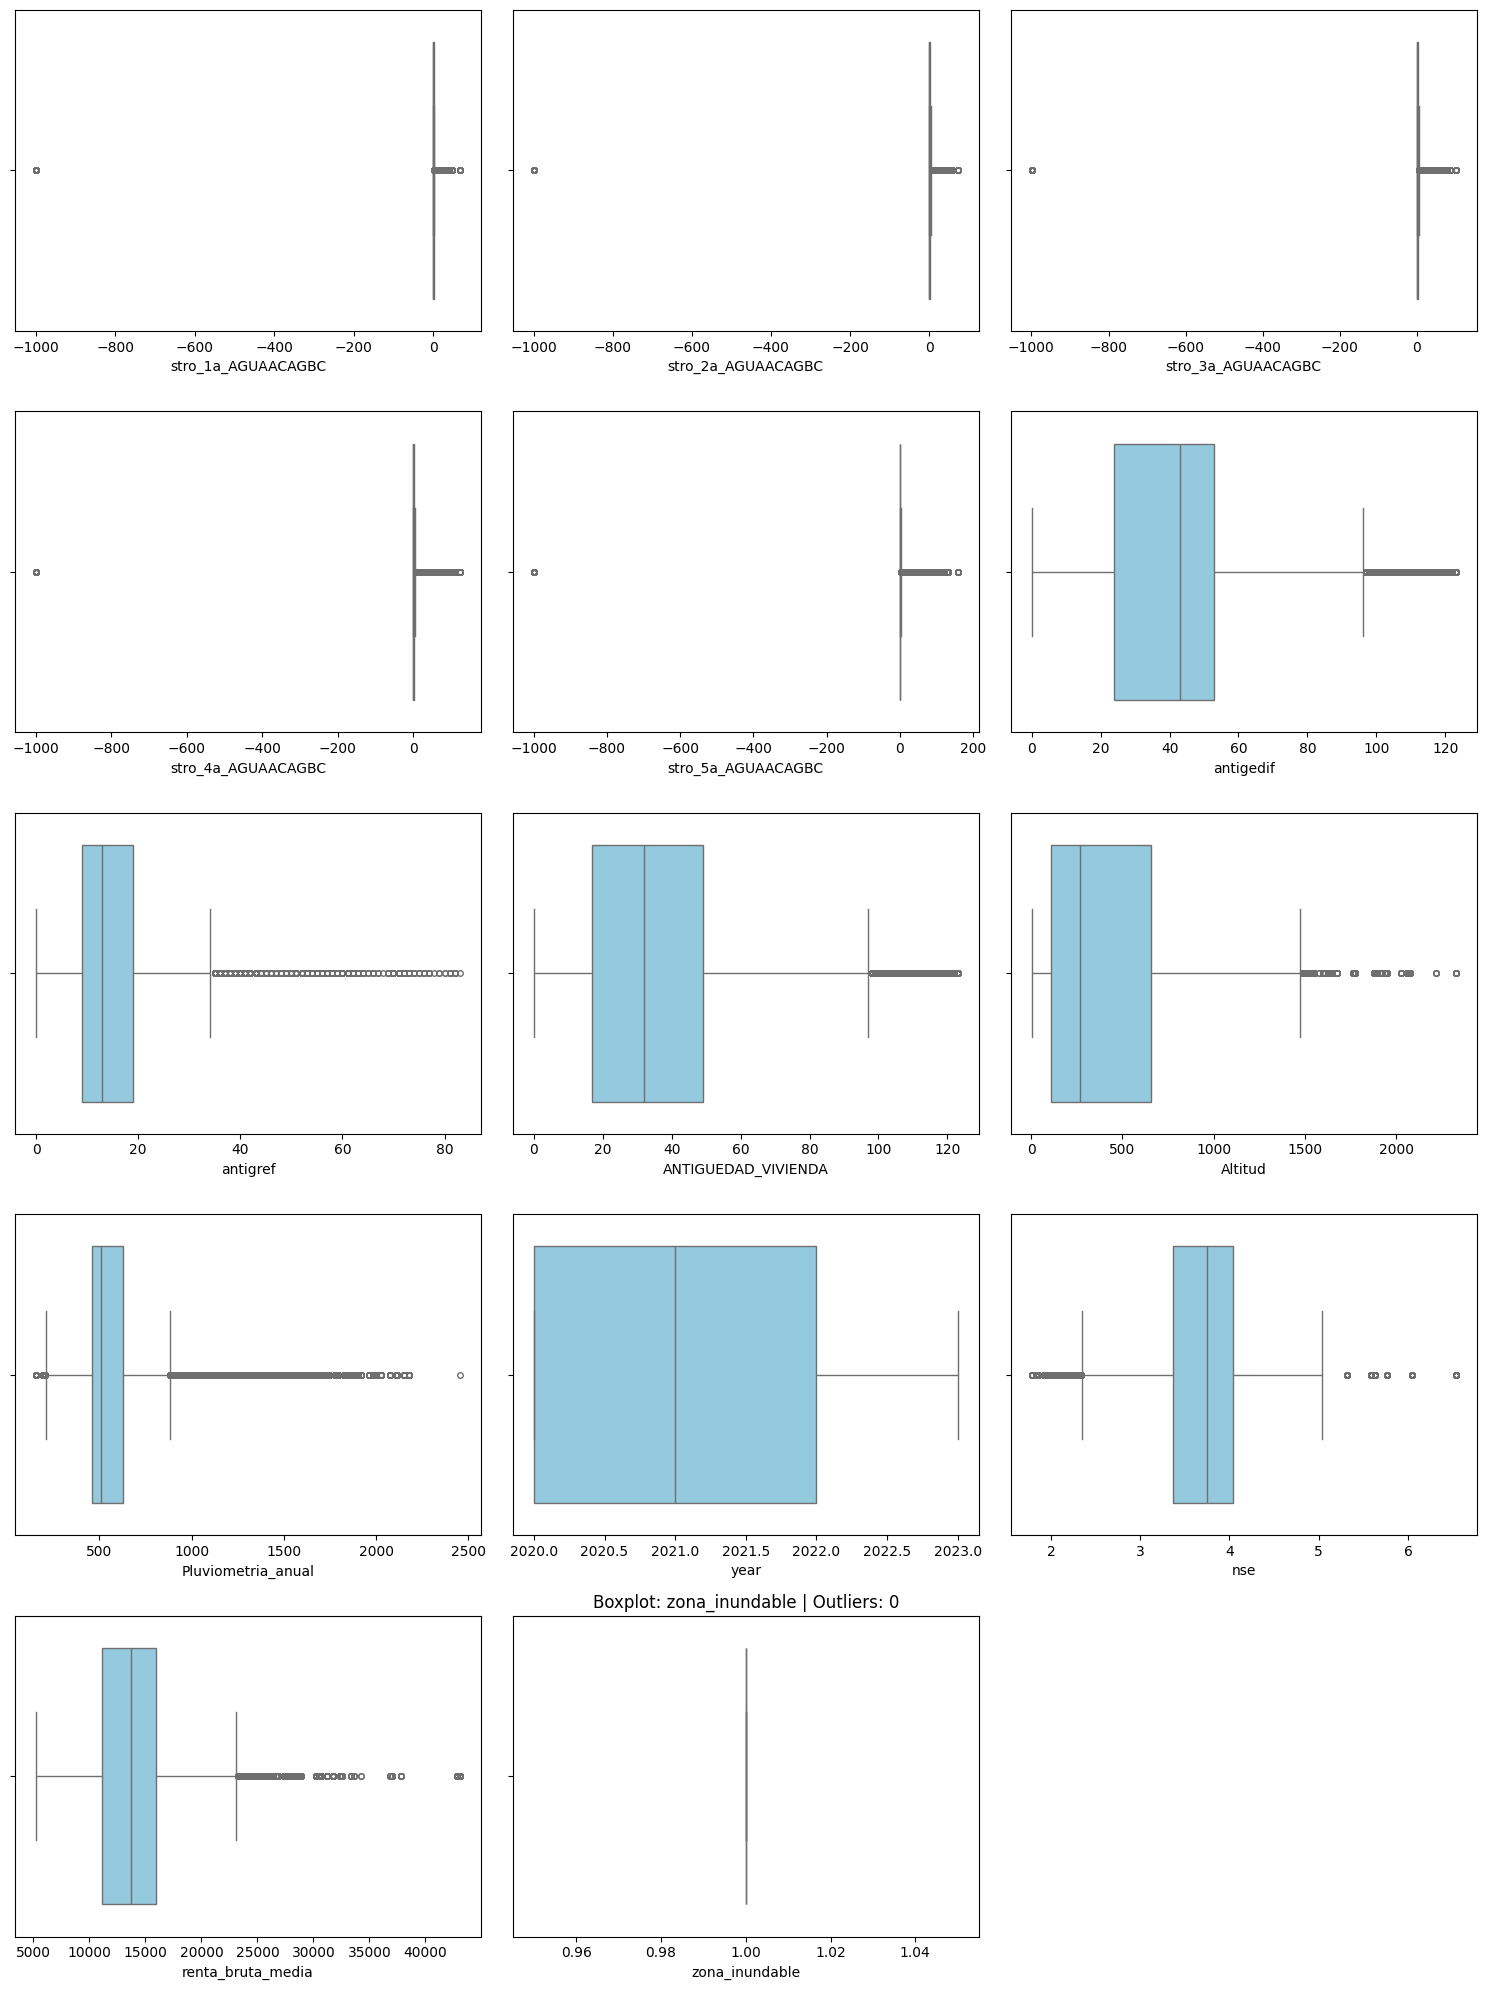

In [106]:
# Boxplots para variables numéricas

num_vars = [col for col in factores if df[col].dtype != 'object']
n = len(num_vars)
cols = 3
rows = math.ceil(n / cols)
plt.figure(figsize=(5 * cols, 4 * rows))
for i, var in enumerate(num_vars, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(
        x=df[var],
        color="skyblue",
        fliersize=5,
        flierprops=dict(marker='o', color='red', markersize=4)
    )
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df[var] < q1 - 1.5 * iqr) | (df[var] > q3 + 1.5 * iqr)]
    outlier_count = outliers[var].count()
plt.title(f"Boxplot: {var} | Outliers: {outlier_count}")
plt.tight_layout()
plt.show()


In [107]:

# Imputar NaNs con la moda por columna en factores
for col in factores:
    if df[col].isnull().any():
        moda = df[col].mode(dropna=True)
        if not moda.empty:
            df[col].fillna(moda[0], inplace=True)

<ipython-input-107-fc387e8a2947>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(moda[0], inplace=True)


In [108]:
# Ajustar outliers por winsorización (percentil 0.5% y 99.5%)
for col in factores:
    if df[col].dtype != 'object':
        q_low = df[col].quantile(0.005)
        q_high = df[col].quantile(0.995)
        df[col] = np.clip(df[col], q_low, q_high)

In [109]:
# Validación de nulos por columna

missing_summary = df[factores].isnull().sum()
print("Cantidad de valores nulos por factor:")
print(missing_summary[missing_summary > 0].sort_values(ascending=False))

Cantidad de valores nulos por factor:
Series([], dtype: int64)


Top factores correlacionados con FRECUENCIA: ['renta_bruta_media', 'nse', 'Altitud', 'Pluviometria_anual', 'year']
Top factores correlacionados con SEVERIDAD: ['Pluviometria_anual', 'nse', 'renta_bruta_media', 'antigedif', 'ANTIGUEDAD_VIVIENDA']


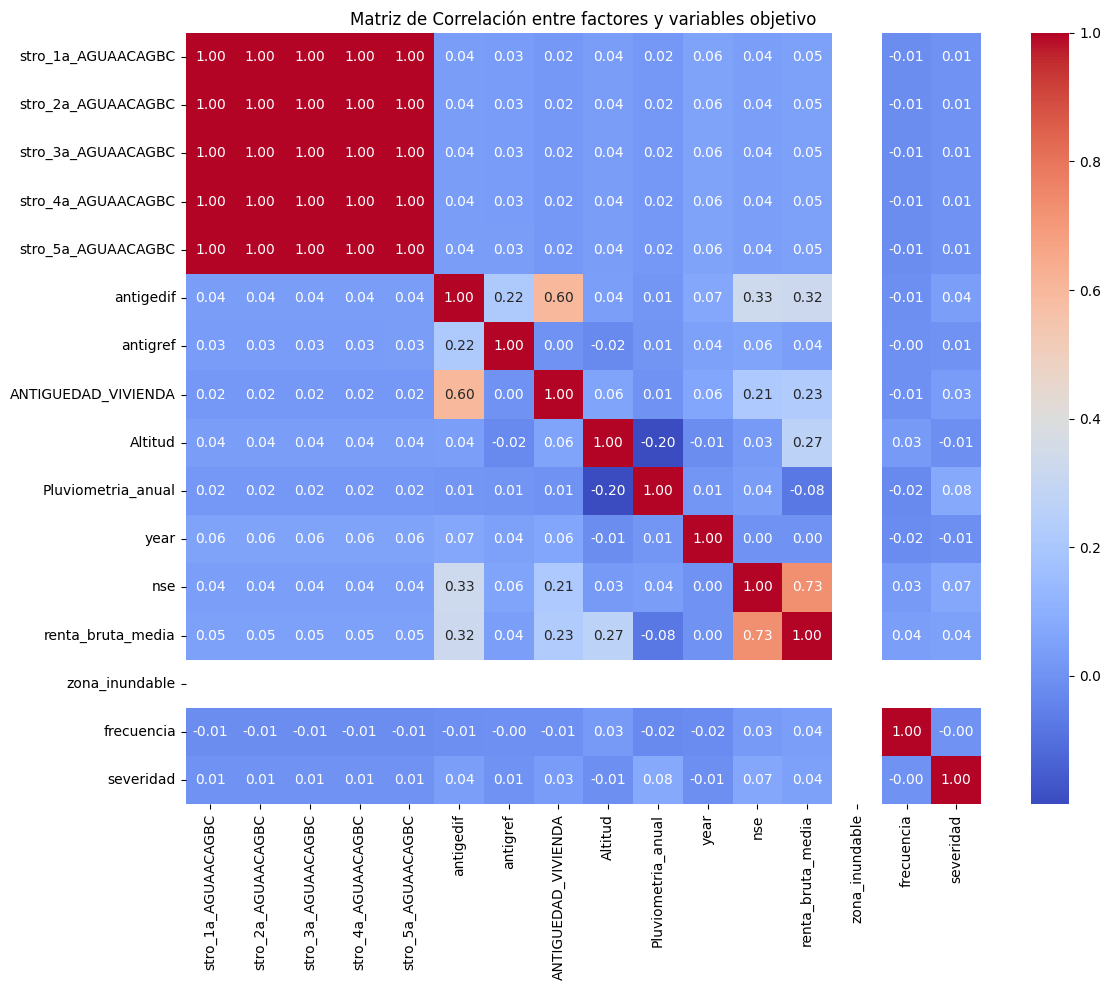

In [110]:
# -----------------------------
# Correlación

# Identificar factores más correlacionados con las variables objetivo
num_vars = [col for col in factores if df[col].dtype != 'object']
cor_matrix = df[num_vars + ["frecuencia", "severidad"]].corr()

# Selección de top variables correlacionadas con frecuencia y severidad
top_frecuencia = cor_matrix["frecuencia"].drop("frecuencia").abs().sort_values(ascending=False).head(5).index.tolist()
top_severidad = cor_matrix["severidad"].drop("severidad").abs().sort_values(ascending=False).head(5).index.tolist()

print("Top factores correlacionados con FRECUENCIA:", top_frecuencia)
print("Top factores correlacionados con SEVERIDAD:", top_severidad)

# -----------------------------
num_vars = [col for col in factores if df[col].dtype != 'object']
cor_matrix = df[num_vars + ["frecuencia", "severidad"]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación entre factores y variables objetivo")
plt.tight_layout()
plt.show()


#Frecuencia

In [111]:
# -----------------------------
# Parte 1: FRECUENCIA - Evaluar los modelos
# -----------------------------
factores_freq_1 = ["antigedif", "antigref", "ANTIGUEDAD_VIVIENDA"]
factores_freq_2 = factores  # modelo completo

# Modelo 1: solo antigüedad
formula_freq_1 = "frecuencia ~ " + " + ".join(factores_freq_1)
yf1, Xf1 = patsy.dmatrices(formula_freq_1, data=df, return_type='dataframe')
result_f1 = sm.GLM(yf1, Xf1, family=sm.families.Poisson()).fit()
df_f1 = yf1.copy()
df_f1["pred"] = result_f1.predict(Xf1)

# Modelo 2: completo todos los factores
factores_formula = " + ".join([f"C({f})" if df[f].dtype == "object" else f for f in factores_freq_2])
formula_freq_2 = f"frecuencia ~ {factores_formula}"
yf2, Xf2 = patsy.dmatrices(formula_freq_2, data=df, return_type='dataframe')
result_f2 = sm.GLM(yf2, Xf2, family=sm.families.Poisson()).fit()
df_f2 = yf2.copy()
df_f2["pred"] = result_f2.predict(Xf2)

# Modelo 3 reducido a los valores significativos
formula_freq_reducido = "frecuencia ~ " + " + ".join(top_frecuencia)
yfr, Xfr = patsy.dmatrices(formula_freq_reducido, data=df, return_type='dataframe')
result_frecuencia_red = sm.GLM(yfr, Xfr, family=sm.families.Poisson()).fit()
df_fr_eval = yfr.copy()
df_fr_eval["pred"] = result_frecuencia_red.predict(Xfr)




📊 Frecuencia - Modelo 1 (Antigüedad)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               542164
Model:                            GLM   Df Residuals:                   542160
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0932e+07
Date:                Fri, 11 Apr 2025   Deviance:                   2.1307e+07
Time:                        01:32:50   Pearson chi2:                 1.14e+08
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02991
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

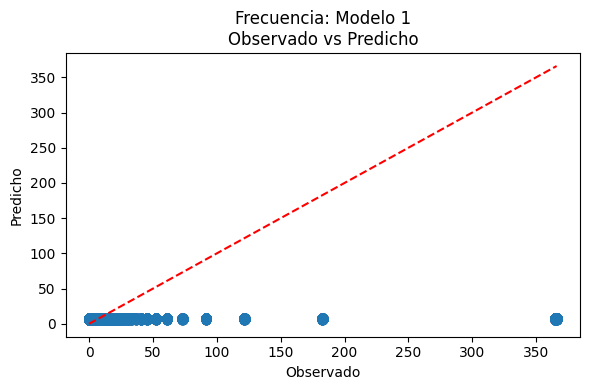

In [112]:
# Métricas y gráficos
print("\n📊 Frecuencia - Modelo 1 (Antigüedad)")
print(result_f1.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_f1["frecuencia"], df_f1["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_f1["frecuencia"], df_f1["pred"], alpha=0.3)
plt.plot([0, df_f1["frecuencia"].max()], [0, df_f1["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 1\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()



📊 Frecuencia - Modelo 2 (Completo)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               542164
Model:                            GLM   Df Residuals:                   542149
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0685e+07
Date:                Fri, 11 Apr 2025   Deviance:                   2.0813e+07
Time:                        01:32:52   Pearson chi2:                 1.15e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.6096
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

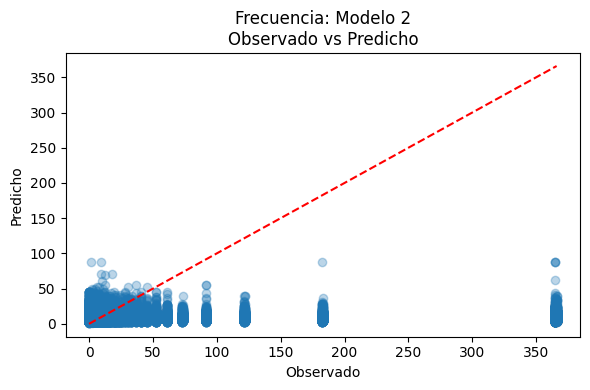

In [113]:
print("\n📊 Frecuencia - Modelo 2 (Completo)")
print(result_f2.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_f2["frecuencia"], df_f2["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_f2["frecuencia"], df_f2["pred"], alpha=0.3)
plt.plot([0, df_f2["frecuencia"].max()], [0, df_f2["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

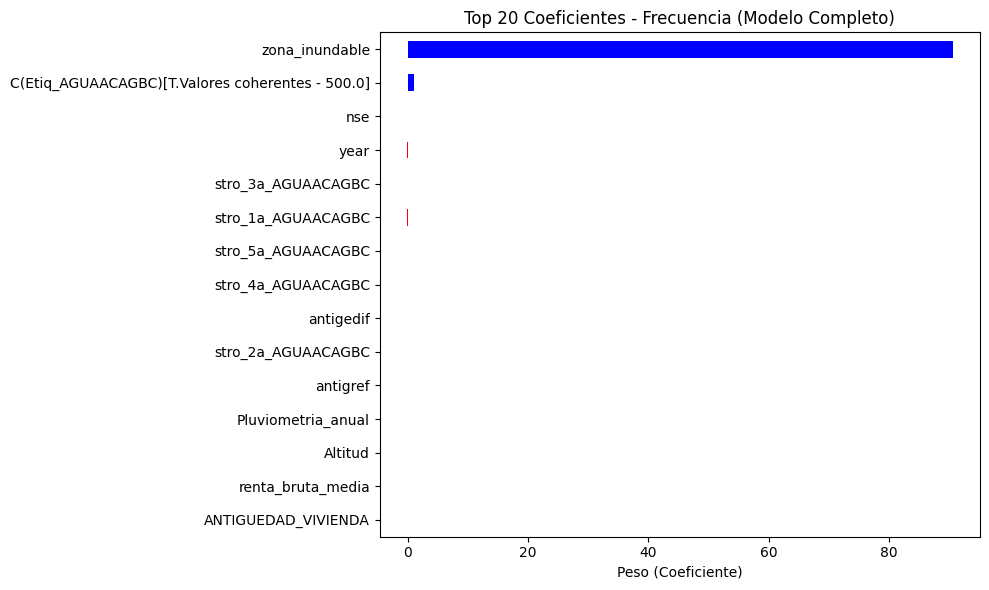

In [114]:
# Importancia de variables
coef_freq = result_f2.params.drop("Intercept").sort_values(key=abs, ascending=False)
colors = ["blue" if c > 0 else "red" for c in coef_freq.head(20)]
plt.figure(figsize=(10, 6))
coef_freq.head(20).plot(kind='barh', color=colors)
plt.title("Top 20 Coeficientes - Frecuencia (Modelo Completo)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📊 Modelo Reducido - Frecuencia
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               542164
Model:                            GLM   Df Residuals:                   542158
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0789e+07
Date:                Fri, 11 Apr 2025   Deviance:                   2.1021e+07
Time:                        01:32:54   Pearson chi2:                 1.14e+08
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4274
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Inter

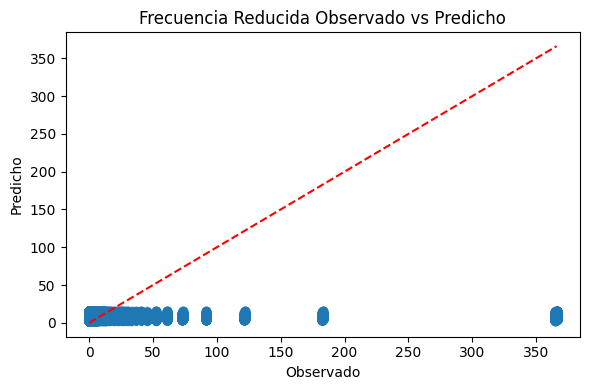

In [115]:
# Modelo reducido de FRECUENCIA

print("📊 Modelo Reducido - Frecuencia")
print(result_frecuencia_red.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_fr_eval["frecuencia"], df_fr_eval["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_fr_eval["frecuencia"], df_fr_eval["pred"], alpha=0.3)
plt.plot([0, df_fr_eval["frecuencia"].max()], [0, df_fr_eval["frecuencia"].max()], 'r--')
plt.title("Frecuencia Reducida Observado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

#Severidad

In [116]:
# -----------------------------
# Parte 2: SEVERIDAD - Evaluar los modelos
# -----------------------------
df_sev = df[df["severidad"] > 0].copy()
factores_sev_1 = ["antigedif", "antigref", "ANTIGUEDAD_VIVIENDA"]
factores_sev_2 = factores  # modelo completo

# Modelo 1: solo antigüedad
formula_sev_1 = "severidad ~ " + " + ".join(factores_sev_1)
ys1, Xs1 = patsy.dmatrices(formula_sev_1, data=df_sev, return_type='dataframe')
result_s1 = sm.GLM(ys1, Xs1, family=sm.families.Gamma(sm.families.links.log())).fit()
df_s1 = ys1.copy()
df_s1["pred"] = result_s1.predict(Xs1)

# Modelo 2: completo
factores_formula_sev = " + ".join([f"C({f})" if df_sev[f].dtype == "object" else f for f in factores_sev_2])
formula_sev_2 = f"severidad ~ {factores_formula_sev}"
ys2, Xs2 = patsy.dmatrices(formula_sev_2, data=df_sev, return_type='dataframe')
result_s2 = sm.GLM(ys2, Xs2, family=sm.families.Gamma(sm.families.links.log())).fit()
df_s2 = ys2.copy()
df_s2["pred"] = result_s2.predict(Xs2)

# Modelo 3 reducido a los factores significativos
formula_sev_reducido = "severidad ~ " + " + ".join(top_severidad)
df_sev_red = df[df["severidad"] > 0].copy()
ysr, Xsr = patsy.dmatrices(formula_sev_reducido, data=df_sev_red, return_type='dataframe')
result_severidad_red = sm.GLM(ysr, Xsr, family=sm.families.Gamma(sm.families.links.log())).fit()
df_sr_eval = ysr.copy()
df_sr_eval["pred"] = result_severidad_red.predict(Xsr)

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(



📊 Severidad - Modelo 1 (Antigüedad)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151443
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                          1.6574
Method:                          IRLS   Log-Likelihood:            -1.0763e+06
Date:                Fri, 11 Apr 2025   Deviance:                   2.1810e+05
Time:                        01:33:03   Pearson chi2:                 2.51e+05
No. Iterations:                    12   Pseudo R-squ. (CS):           0.001994
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

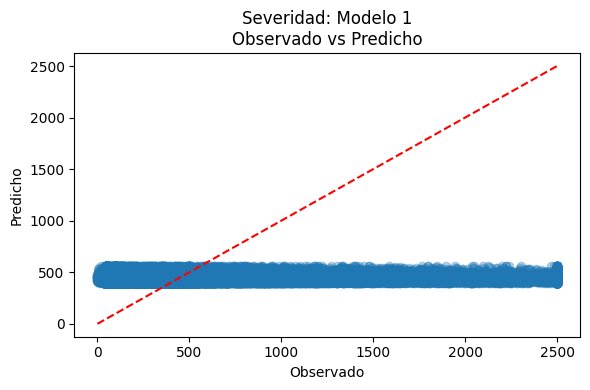

In [117]:
# Métricas y gráficos
print("\n📊 Severidad - Modelo 1 (Antigüedad)")
print(result_s1.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_s1["severidad"], df_s1["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_s1["severidad"], df_s1["pred"], alpha=0.3)
plt.plot([0, df_s1["severidad"].max()], [0, df_s1["severidad"].max()], 'r--')
plt.title("Severidad: Modelo 1\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Severidad - Modelo 2 (Completo)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151432
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                          1.6439
Method:                          IRLS   Log-Likelihood:            -1.0754e+06
Date:                Fri, 11 Apr 2025   Deviance:                   2.1574e+05
Time:                        01:33:04   Pearson chi2:                 2.49e+05
No. Iterations:                    18   Pseudo R-squ. (CS):            0.01139
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

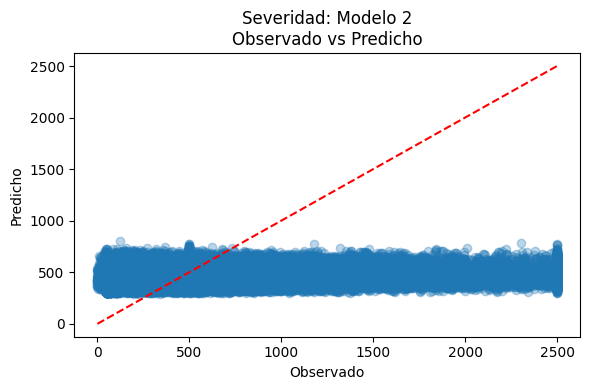

In [118]:
print("\n📊 Severidad - Modelo 2 (Completo)")
print(result_s2.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_s2["severidad"], df_s2["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_s2["severidad"], df_s2["pred"], alpha=0.3)
plt.plot([0, df_s2["severidad"].max()], [0, df_s2["severidad"].max()], 'r--')
plt.title("Severidad: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

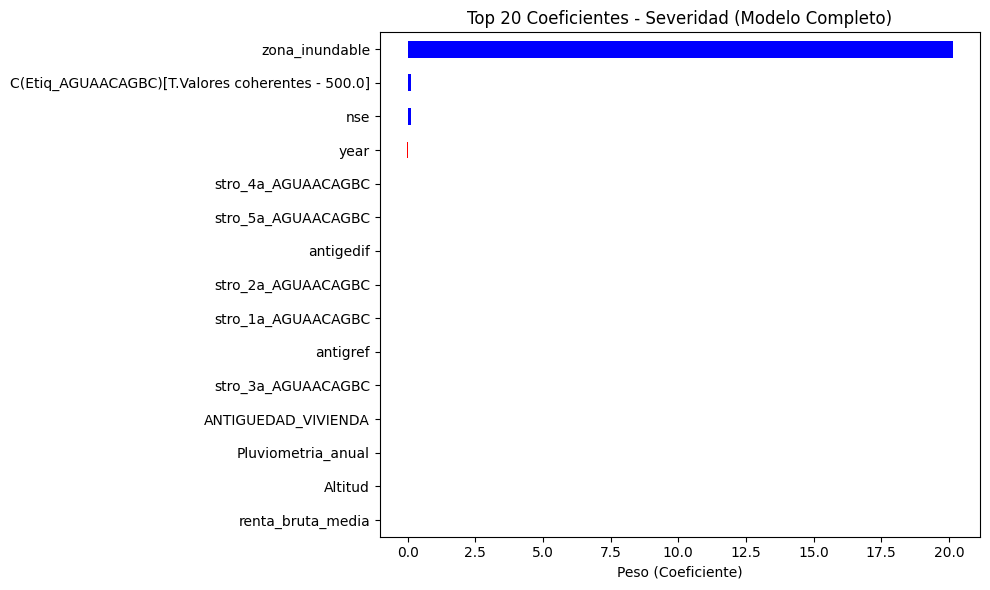

In [119]:
# Importancia de variables - Severidad
coef_sev = result_s2.params.drop("Intercept").sort_values(key=abs, ascending=False)
colors = ["blue" if c > 0 else "red" for c in coef_sev.head(20)]
plt.figure(figsize=(10, 6))
coef_sev.head(20).plot(kind='barh', color=colors)
plt.title("Top 20 Coeficientes - Severidad (Modelo Completo)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📊 Modelo Reducido - Severidad
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          1.6380
Method:                          IRLS   Log-Likelihood:            -1.0753e+06
Date:                Fri, 11 Apr 2025   Deviance:                   2.1585e+05
Time:                        01:33:05   Pearson chi2:                 2.48e+05
No. Iterations:                    12   Pseudo R-squ. (CS):            0.01103
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

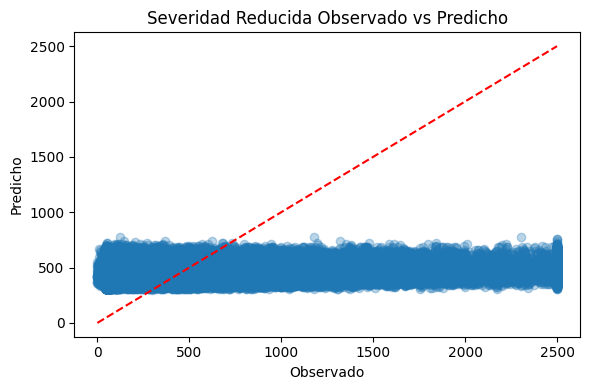

In [120]:
# Modelo reducido a los factores significativos

print("📊 Modelo Reducido - Severidad")
print(result_severidad_red.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_sr_eval["severidad"], df_sr_eval["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_sr_eval["severidad"], df_sr_eval["pred"], alpha=0.3)
plt.plot([0, df_sr_eval["severidad"].max()], [0, df_sr_eval["severidad"].max()], 'r--')
plt.title("Severidad Reducida Observado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

Pseudo R² Frecuencia - Completo: 0.0239
Pseudo R² Frecuencia - Reducido: 0.0142


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Pseudo R² Severidad - Completo: 0.0130
Pseudo R² Severidad - Reducido: 0.0126


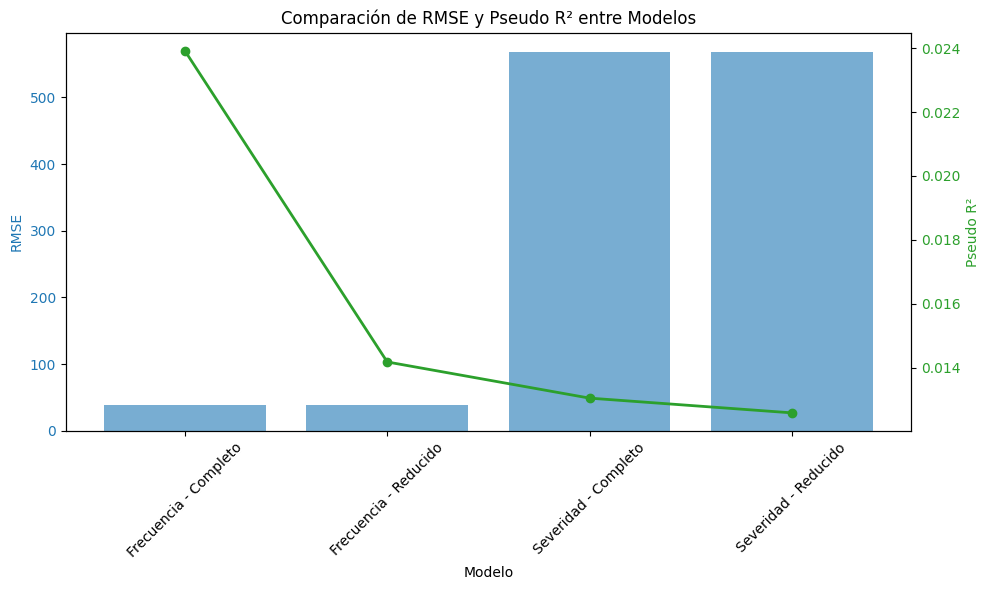

In [121]:
# -----------------------------
# Paso Extra: Cálculo de Pseudo R² para modelos GLM

# Pseudo R² para Frecuencia - Modelo Completo
null_model_f2 = sm.GLM(yf2, np.ones((yf2.shape[0], 1)), family=sm.families.Poisson()).fit()
pseudo_r2_f2 = 1 - result_f2.deviance / null_model_f2.deviance
print(f"Pseudo R² Frecuencia - Completo: {pseudo_r2_f2:.4f}")

# Pseudo R² para Frecuencia - Modelo Reducido
null_model_fr = sm.GLM(yfr, np.ones((yfr.shape[0], 1)), family=sm.families.Poisson()).fit()
pseudo_r2_fr = 1 - result_frecuencia_red.deviance / null_model_fr.deviance
print(f"Pseudo R² Frecuencia - Reducido: {pseudo_r2_fr:.4f}")

# Pseudo R² para Severidad - Modelo Completo
null_model_s2 = sm.GLM(ys2, np.ones((ys2.shape[0], 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2_s2 = 1 - result_s2.deviance / null_model_s2.deviance
print(f"Pseudo R² Severidad - Completo: {pseudo_r2_s2:.4f}")

# Pseudo R² para Severidad - Modelo Reducido
null_model_sr = sm.GLM(ysr, np.ones((ysr.shape[0], 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2_sr = 1 - result_severidad_red.deviance / null_model_sr.deviance
print(f"Pseudo R² Severidad - Reducido: {pseudo_r2_sr:.4f}")


# Calcular RMSE para modelos completos
df_f2["pred"] = result_f2.predict(Xf2)
rmse_frec_completo = np.sqrt(mean_squared_error(df_f2["frecuencia"], df_f2["pred"]))

df_s2["pred"] = result_s2.predict(Xs2)
rmse_sev_completo = np.sqrt(mean_squared_error(df_s2["severidad"], df_s2["pred"]))


# Gráfico comparativo de RMSE y Pseudo R²
metrics_df = pd.DataFrame({
    "Modelo": [
        "Frecuencia - Completo", "Frecuencia - Reducido",
        "Severidad - Completo", "Severidad - Reducido"
    ],
    "RMSE": [
        rmse_frec_completo, np.sqrt(mean_squared_error(df_fr_eval["frecuencia"], df_fr_eval["pred"])),
        rmse_sev_completo, np.sqrt(mean_squared_error(df_sr_eval["severidad"], df_sr_eval["pred"]))
    ],
    "Pseudo R²": [
        pseudo_r2_f2, pseudo_r2_fr,
        pseudo_r2_s2, pseudo_r2_sr
    ]
})

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Modelo")
ax1.set_ylabel("RMSE", color=color)
ax1.bar(metrics_df["Modelo"], metrics_df["RMSE"], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Pseudo R²", color=color)
ax2.plot(metrics_df["Modelo"], metrics_df["Pseudo R²"], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Comparación de RMSE y Pseudo R² entre Modelos")
plt.tight_layout()
plt.show()
